**Author:** Umashankar Rajaram  
**CWID:**   A20391260  

**Content:** Machine Learning Analysis on Crime data  
**Purpose:** To assist FBI and Police departments in identifying the areas that trigger crime.  
**Tools:** Python 3.6 as interpreter with Scikit-learn 0.18.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
#Creating a dataframe from the given CSV file
crime_df = pd.read_csv("C:\\Users\\Chandra Balaji\\Desktop\\Notebooks\\datasets\\communities-crime-clean.csv")
print("Dataframe Dimensions: ", crime_df.shape)

Dataframe Dimensions:  (1993, 104)


In [3]:
#Adding a field "highCrime" that has the classfied results
crime_df['highCrime'] = np.where(crime_df['ViolentCrimesPerPop'] > 0.1, 'true', 'false')
#Storing the counts of unique values of the result in a Series object
crimeResult = crime_df['highCrime'].value_counts()
print(crimeResult)

true     1250
false     743
Name: highCrime, dtype: int64


## 1. Decison Trees
### (1.a) Crime percentage:

In [4]:
#------------------Percentage calculation function-------------------------
def class_dist(value, total, classLabel):
        percent = (value/total)*100
        print("Number of '%s' Instances: %d, Percentage: %f%%"%(classLabel, value, percent))
#--------------------------------------------------------------------------

class_dist(crimeResult['true'], crime_df['highCrime'].count(), 'true')
class_dist(crimeResult['false'], crime_df['highCrime'].count(), 'false')

Number of 'true' Instances: 1250, Percentage: 62.719518%
Number of 'false' Instances: 743, Percentage: 37.280482%


### (1.b) Decision Tree Classifier Learning:

In [5]:
from sklearn import tree
from sklearn import preprocessing

#Excluding the crime rate field "ViolentCrimesPerPop" from the dataset
input_df = crime_df.drop('ViolentCrimesPerPop', axis=1)

#Transforming the categorical attribute "çommunityname" into integer values
uniqueStrings = input_df.communityname.unique()
le = preprocessing.LabelEncoder()
le.fit(uniqueStrings)
input_df['communityname'] = le.transform(input_df['communityname'])

#Defining the training attributes and labels for the classifier to learn
features_df = input_df.values[:, :-1]
target_df = input_df.values[:,-1]

#Invoking the Decision Tree Classifier with default arguments
DT_Classifier_def = tree.DecisionTreeClassifier()
DT_Classifier_def.fit(features_df, target_df)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

#### (1.b.i) Training Accuracy, Precision and Recall:

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Prediction with Decision Tree classifier
target_DT_pred = DT_Classifier_def.predict(features_df)

#------ Custom function to calculate prediction metrics of the classifier ------
def prediction_metrics(target_true, target_predicted):
    print("Confusion Matrix: \n",confusion_matrix(target_true, target_predicted, labels = ['true', 'false']))
    print("\nAccuracy(%): \n", round(accuracy_score(target_true, target_predicted)*100, 2))
    print("\nPresicion(%): \n", round(precision_score(target_true, target_predicted, pos_label='true', average='binary')*100, 2))
    print("\nRecall(%): \n", round(recall_score(target_true, target_predicted, pos_label='true', average='binary')*100, 2))
#-------------------------------------------------------------------------------

print("\nDECISION TREE CLASSIFIER WITH \"DEFAULT\" ARGUMENTS - PREDICTION RESULTS:\n")
prediction_metrics(target_df, target_DT_pred)


DECISION TREE CLASSIFIER WITH "DEFAULT" ARGUMENTS - PREDICTION RESULTS:

Confusion Matrix: 
 [[1250    0]
 [   0  743]]

Accuracy(%): 
 100.0

Presicion(%): 
 100.0

Recall(%): 
 100.0


##### Observation:
> We find that the Decision tree algorithm with default arguments classifies the dataset perfectly with all the prediction metrics turning 100%. However, we can't proceed with this prediction as this just worked on training dataset and the classifier, using best possible default values, would have over-generalized the decision tree. This would be evident when we evaluate the classifier with **Cross-Validation** algorithm.

### (1.c) Cross-Validation to evaluate the Decision tree classifier's performance:
#### (1.c.i) 10-fold Cross-Validation Accuracy, Precision and Recall score:


EVALUATION OF DECISION TREE CLASSIFIER - with default arguments:



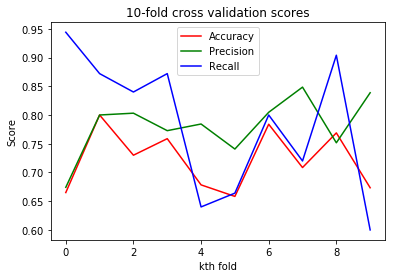

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 72.2515075377
Precision(%): 
 78.1860466146
Recall(%): 
 78.56


In [7]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#----- Custom Function to transform class labels (true/false) into binary values (1/0)
def binarizer(inputSeq):
    lb = preprocessing.LabelBinarizer()
    return np.array([number[0] for number in lb.fit_transform(inputSeq)])
#-----------------------------------------------------------------------------
   
    
#----- Custom function to calculate 10-fold cross validation scores -----
def cv10_evalulate(classifier, features, target):
    target_bin = binarizer(target)
    cv10_accuracy = cross_val_score(classifier, features, target, cv=10)
    cv10_precision = cross_val_score(classifier, features, target_bin, cv=10, scoring='precision')
    cv10_recall = cross_val_score(classifier, features, target_bin, cv=10, scoring='recall')

    #Plotting the cross-validation scores
    plt.title("10-fold cross validation scores")
    plt.plot(range(10), cv10_accuracy, color="r", label='Accuracy')
    plt.plot(range(10), cv10_precision, color="g", label='Precision')
    plt.plot(range(10), cv10_recall, color="b", label='Recall')
    plt.xlabel('kth fold')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

    #Printing the mean socres
    print("10-fold Cross validation (Mean) scores: \n")
    print("Accuracy(%): \n", np.mean(cv10_accuracy)*100)
    print("Precision(%): \n", np.mean(cv10_precision)*100)
    print("Recall(%): \n", np.mean(cv10_recall)*100)
#------------------------------------------------------------------------

print("\nEVALUATION OF DECISION TREE CLASSIFIER - with default arguments:\n")
cv10_evalulate(DT_Classifier_def, features_df, target_df)

##### Observation:
> As we expected, the prediction metrics are worse. We can see that the accuracy value (currently observed) is 71.44%, which is a **28.56% drop!** So, we ned to tune the Decision tree classifier's arguments so that it will generalize better and score well in evaluations.

In [8]:
#Invoking Decision tree classifier with some custom arguments and changed name (DT_Classifier1)
DT_Classifier1 = tree.DecisionTreeClassifier(criterion = 'gini', random_state=100, max_depth=4, \
                                             min_samples_split=80, min_samples_leaf=20)
DT_Classifier1.fit(features_df, target_df)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=80, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [9]:
#Prediction with the new Decision Tree classifier
target_DT_pred = DT_Classifier1.predict(features_df)

print("\nDECISION TREE CLASSIFIER WITH \"CUSTOM\" ARGUMENTS - PREDICTION RESULTS:\n")
prediction_metrics(target_df, target_DT_pred)


DECISION TREE CLASSIFIER WITH "CUSTOM" ARGUMENTS - PREDICTION RESULTS:

Confusion Matrix: 
 [[1026  224]
 [  95  648]]

Accuracy(%): 
 83.99

Presicion(%): 
 91.53

Recall(%): 
 82.08


##### Observation:
> We find that the classifier with custom arguments has lower predicition metrics (not bad though) than that of the one with default arguments. Now, lets evaluate its performance using Cross Validation evaluator.


EVALUATION OF DECISION TREE CLASSIFIER - with custom arguments:



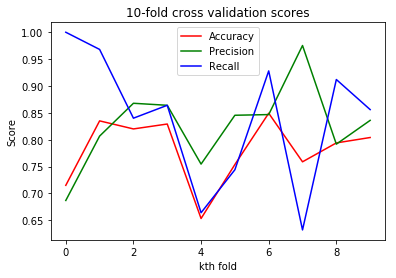

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 78.1221105528
Precision(%): 
 82.7487658563
Recall(%): 
 84.08


In [10]:
print("\nEVALUATION OF DECISION TREE CLASSIFIER - with custom arguments:\n")
cv10_evalulate(DT_Classifier1, features_df, target_df)

##### Observation:
> As observed, we got better evaluation results now with all the statistics showing an above average performance. So, we achieved a good generalization for the Decision tree classifier with some tuning. Let's stick here.

#### (1.b.ii) Main features used for classification:
The main features can be identified by the measure of **"Gini importance"** assigned by the classifier. It is a "mean decrease impurity" and is defined as the total decrease in node impurity.

Feature ranking based on measurements:
1.) feature 47 [PctKids2Par], Gini Importance = 0.665281
2.) feature 6 [racePctWhite], Gini Importance = 0.155528
3.) feature 8 [racePctHisp], Gini Importance = 0.084692
4.) feature 74 [HousVacant], Gini Importance = 0.018573
5.) feature 29 [HispPerCap], Gini Importance = 0.016833
6.) feature 88 [MedRent], Gini Importance = 0.012833
7.) feature 78 [PctVacMore6Mos], Gini Importance = 0.011662
8.) feature 44 [TotalPctDiv], Gini Importance = 0.011362
9.) feature 42 [MalePctNevMarr], Gini Importance = 0.009494
10.) feature 0 [state], Gini Importance = 0.008023


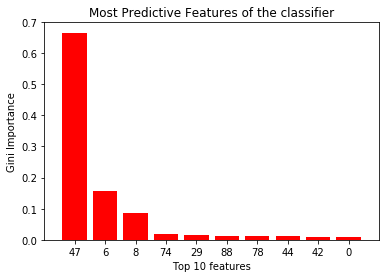

In [11]:
#Extracting the feature importances established by the classifier
f_importances = DT_Classifier1.feature_importances_
feature_ranks_DT = np.argsort(f_importances)[::-1]

#Shortlisting the top 10 features chosen by the classifier
mostPred10Features_DT = feature_ranks_DT[:10]

#------- Custom Function to display the 10 most predictive features --------
def displayTop10Features(dataset, measuredValues, mostPred10Features, ylabel): 
    print("Feature ranking based on measurements:")
    for i in range(10):
        print("%d.) feature %d [%s], %s = %f" % (i + 1, mostPred10Features[i], 
                    dataset.columns[mostPred10Features[i]], ylabel, measuredValues[mostPred10Features[i]]))

    #Plotting the results
    plt.title("Most Predictive Features of the classifier")
    plt.bar(range(10), measuredValues[mostPred10Features], color="r", align="center")
    plt.xticks(range(10), mostPred10Features)
    plt.xlabel('Top 10 features')
    plt.ylabel(ylabel)
    plt.xlim([-1, 10])
    plt.show()
#---------------------------------------------------------------------------
    
displayTop10Features(input_df, f_importances, mostPred10Features_DT, 'Gini Importance')

##### Observation:
> Some of the main features chosen by the classifier for the perfect split are:   
* PctKids2Par - Percentage of kids in family housing with two parents
* racePctWhite - Percentage of population that is caucasian
* racePctHisp - Percentage of population that is of hispanic heritage
* PctVacMore6Mos - Percent of vacant housing that has been vacant more than 6 months
* MalePctNevMarr - Percentage of males who have never married  

>and so on..

> The prediction shows that majority of the cases of crime could have happened because of **racial** issues, as given by their higher (Gini) importances - rank 2 and 3. House **vacancies** at rank 4 and 7 tells that abandonment of properties could factor in increasing crime rates. Also we have unmarried males chosen by the classifier which is at rank 9. So, it says that **men who are alone** are prone to indulge in activities that sometimes lead to crimes. Further, this attribute could be related to the others (racial and vacancy issues) as decribed above.

## 2. Linear Classification
### (2.a) Gaussian Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB
gNB_Classifier = GaussianNB()

'''
Note: "communityname" attribute is categorical, which we encoded before. 
DT classifier found its feature_importance as '0' and so we could take that
its absence doesn't affect the classification accuray. Now, we can drop 
this attribute before normalizing the dataframe.
'''
#Dropping the ""communityname" feature, 
#Renaming the dataframe as "input_df2" (Shape: 1993x103), &
#Altering the training dataset
input_df2 = input_df.drop(['communityname'], axis=1)
features_df2 = input_df2.values[:, :-1]
target_df2 = input_df2.values[:,-1]

gNB_Classifier.fit(features_df2, target_df2)

GaussianNB(priors=None)

In [13]:
#Prediction with Gaussian Naive Bayes classifier
target_gNB_pred = gNB_Classifier.predict(features_df2)
print("\nGAUSSIAN_NB CLASSIFIER - PREDICTION RESULTS:\n")
prediction_metrics(target_df2, target_gNB_pred)


GAUSSIAN_NB CLASSIFIER - PREDICTION RESULTS:

Confusion Matrix: 
 [[869 381]
 [ 64 679]]

Accuracy(%): 
 77.67

Presicion(%): 
 93.14

Recall(%): 
 69.52


#### (2.a.i) 10-fold Cross-Validation to evaluate the GaussianNB classifier's performance:


GAUSSIAN_NB CLASSIFIER - CROSS VALIDATION RESULTS: 



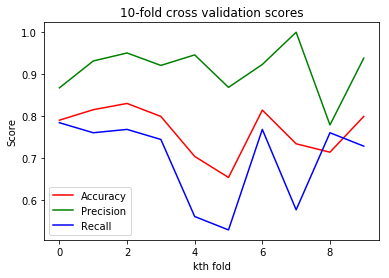

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 76.5108040201
Precision(%): 
 91.2419309104
Recall(%): 
 69.76


In [14]:
print("\nGAUSSIAN_NB CLASSIFIER - CROSS VALIDATION RESULTS: \n")
cv10_evalulate(gNB_Classifier, features_df2, target_df2)

##### Observation:
> Based on the results, we find that evaluation metrics are similar to the prediction on training data, even the recall score of the evalution is far better. So, the GaussianNB classifer has **good generalization** for the crime dataset.


#### (2.a.ii) 10 most predictive features for the GaussianNB classifier

In [15]:
#Finding Normalized Absolute difference of Means between 2 classes of "highCrime"

#Calcualting the class-wise means of every attribute in the dataframe
input_df2_mean = input_df2.groupby('highCrime').mean()
print("Class-wise Means of the attributes: ")
input_df2_mean

Class-wise Means of the attributes: 


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
highCrime,,,,,,,,,,,,,,,,,,,,,
false,33.004038,5.450875,0.020444,0.480713,0.047699,0.913459,0.132423,0.050269,0.415828,0.46463,...,0.000767,0.161965,0.63996,0.590444,0.629906,0.666097,0.051036,0.176729,0.153742,0.018250
true,26.116000,5.523200,0.079704,0.453168,0.257408,0.659192,0.166432,0.199856,0.429192,0.51132,...,0.035880,0.247568,0.59024,0.501992,0.624192,0.642776,0.073688,0.266304,0.166496,0.139184


In [16]:
#Calcualting the class-wise standard-deviation of every attribute in the dataframe
input_df2_std = input_df2.groupby('highCrime').std()
print("Class-wise Standard-deviation of the attributes: ")
input_df2_std

Class-wise Standard-deviation of the attributes: 


,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
highCrime,,,,,,,,,,,,,,,,,,,,,
false,14.653178,2.865812,0.026123,0.151243,0.075765,0.089176,0.164436,0.091442,0.169803,0.154259,...,0.005994,0.147616,0.190410,0.198365,0.213573,0.200821,0.061674,0.149191,0.211070,0.105931
true,16.845936,2.877514,0.154860,0.169974,0.286641,0.256820,0.230451,0.270036,0.145730,0.133906,...,0.124912,0.263691,0.210038,0.161748,0.192398,0.196275,0.129100,0.222686,0.239127,0.282900


**Now, we need to calculate $\frac{|{\mu_T - \mu_F}|}{\sigma_T + \sigma_F}$ that gives the Normalized Absolute Difference of Means for the feature between the two classes.**

Feature ranking based on measurements:
1.) feature 46 [PctKids2Par], Norm_Abs_Diff_Means = 0.809336
2.) feature 45 [PctFam2Par], Norm_Abs_Diff_Means = 0.745162
3.) feature 5 [racePctWhite], Norm_Abs_Diff_Means = 0.734884
4.) feature 52 [PctIlleg], Norm_Abs_Diff_Means = 0.708929
5.) feature 42 [FemalePctDiv], Norm_Abs_Diff_Means = 0.693604
6.) feature 43 [TotalPctDiv], Norm_Abs_Diff_Means = 0.674282
7.) feature 47 [PctYoungKids2Par], Norm_Abs_Diff_Means = 0.664671
8.) feature 17 [pctWInvInc], Norm_Abs_Diff_Means = 0.660720
9.) feature 48 [PctTeen2Par], Norm_Abs_Diff_Means = 0.642621
10.) feature 40 [MalePctDivorce], Norm_Abs_Diff_Means = 0.616534


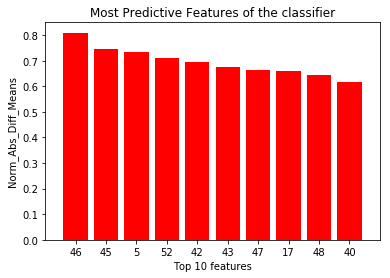

In [17]:
#Preparing the data - Converting the Panda DataFrames into Numpy Arrays
input_df2_mean_np = np.array(input_df2_mean)
input_df2_std_np = np.array(input_df2_std)

#Calculating Normalized Absolute Mean Difference  
abs_diff_means = abs(input_df2_mean_np[1] - input_df2_mean_np[0])/(input_df2_std_np[1] + input_df2_std_np[0])

#Sorting the calculated values
feature_ranks_gNB = np.argsort(abs_diff_means)[::-1]
mostPred10features_gNB = feature_ranks_gNB[:10]

#Displaying the 10 most predictive features
displayTop10Features(input_df2, abs_diff_means, mostPred10features_gNB, 'Norm_Abs_Diff_Means')

##### Observation:
> We identify the most predictive features based on the measurement of Absolute Difference of Means between each class's feature set. In the results, we see that some features as shortlisted by the decision tree classifier (like "PctKids2Par", "racePctWhite", etc) are chosen by GaussianNB classifer too.
Now, **GaussianNB classifier fundametally assumes that the features are independent**. But, when we see its chosen attributes:
* PctKids2Par - Percentage of kids in family housing with two parents
* PctFam2Par - Percentage of families (with kids) that are headed by two parents
* PctYoungKids2Par - Percent of kids 4 and under in two parent households
* PctTeen2Par - Percent of kids age 12-17 in two parent households
* TotalPctDiv - Percentage of population who are divorced
* FemalePctDiv - Percentage of females who are divorced 
* MalePctDivorce - Percentage of males who are divorced 

> We could say that such assumption isn't making sense as most of the main features are inter-related in one or the other way. Hence, though the evaluation results are good for GaussianNB classifier, we can't entirely rely on its prediction.  


### (2.b) LinearSVC
>In this approach, the result is a **hyperplane that separates the classes** in the best way possible. The feature weights, which are nothing but the coefficients given by svm.coef_ , represent the hyperplane, in a way that they represent the coordinates of a vector orthogonal to the hyperplane and also gives the **direction** of the predicted class.

In [18]:
from sklearn import svm
linSVC_Classifier = svm.LinearSVC()
linSVC_Classifier.fit(features_df2, target_df2)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
#Prediction with LinearSVC classifier
target_linSVC_pred = linSVC_Classifier.predict(features_df2)
print("\nLINEAR-SVC CLASSIFIER - PREDICTION RESULTS: \n")
prediction_metrics(target_df2, target_linSVC_pred)


LINEAR-SVC CLASSIFIER - PREDICTION RESULTS: 

Confusion Matrix: 
 [[1027  223]
 [  98  645]]

Accuracy(%): 
 83.89

Presicion(%): 
 91.29

Recall(%): 
 82.16


#### (2.b.i) 10-fold Cross-Validation to evaluate the LinearSVC classifier's performance:


LINEAR_SVC CLASSIFIER - CROSS VALIDATION RESULTS: 



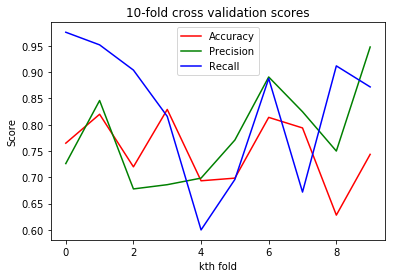

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 75.0600502513
Precision(%): 
 78.1952198967
Recall(%): 
 82.88


In [20]:
print("\nLINEAR_SVC CLASSIFIER - CROSS VALIDATION RESULTS: \n")
cv10_evalulate(linSVC_Classifier, features_df2, target_df2)

##### Observation:
> For LinearSVC classifier, we find that both the results (prediction and evaluation) are good. Now, let us find the most predictive features by finding the feature weights.

#### (2.b.ii) 10 most predictive features for the LinearSVC classifier:

Feature ranking based on measurements:
1.) feature 17 [pctWInvInc], Abs_feature_wieghts = 1.750725
2.) feature 5 [racePctWhite], Abs_feature_wieghts = 1.118237
3.) feature 46 [PctKids2Par], Abs_feature_wieghts = 1.014444
4.) feature 66 [PersPerOccupHous], Abs_feature_wieghts = 0.917992
5.) feature 86 [RentHighQ], Abs_feature_wieghts = 0.875953
6.) feature 40 [MalePctDivorce], Abs_feature_wieghts = 0.852039
7.) feature 8 [agePct12t21], Abs_feature_wieghts = 0.836855
8.) feature 7 [racePctHisp], Abs_feature_wieghts = 0.833210
9.) feature 73 [HousVacant], Abs_feature_wieghts = 0.795263
10.) feature 70 [PctPersDenseHous], Abs_feature_wieghts = 0.761796


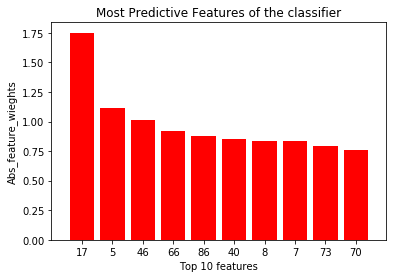

In [21]:
feature_weights = linSVC_Classifier.coef_

#Extracting the feature weights into an 1D array
feature_weights_1Darr = feature_weights[0, :]
abs_feature_weights = abs(feature_weights_1Darr)

feature_ranks_linSVC = np.argsort(abs_feature_weights)[::-1]
mostPred10features_linSVC = feature_ranks_linSVC[:10]
                        
#Displaying the 10 most predictive features
displayTop10Features(input_df2, abs_feature_weights, mostPred10features_linSVC, 'Abs_feature_wieghts')

##### Observation:
> Here, compared with Decision tree classifier's results, there are many features that matches for LinearSVC too. 

## 3.) Regression

### (3.a) LinearRegression

In [22]:
from sklearn import linear_model
linRegr = linear_model.LinearRegression()

#Fitting the Linear regressor, with target as "ViolentCrimesPerPop" feature
linRegr.fit(features_df2, crime_df['ViolentCrimesPerPop'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### (3.a.i) Estimated MSE (Mean Square Error) using 10-fold Cross Validation
> The MSE tells **how closer a regression line is to a set of data points**. It does this by finding the distances from the points to the regression line (these distances are nothing but the “errors”), squaring them, adding them and finally taking a mean on them.

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

#Estimation using 10-fold cross validation
cv10_linReg_pred = cross_val_predict(linRegr, features_df2, crime_df['ViolentCrimesPerPop'], cv=10) 
cv10_linReg_mse = mean_squared_error(crime_df['ViolentCrimesPerPop'], cv10_linReg_pred)
print("\nCross-validation MSE: ", cv10_linReg_mse)


Cross-validation MSE:  0.0199163260696


#### (3.a.ii) MSE on the training set

In [24]:
#Testing the regressor with the training features
linReg_pred = linRegr.predict(features_df2)

#Calculating MSE of the Regressor's prediction
linRegr_mse = mean_squared_error(crime_df['ViolentCrimesPerPop'], linReg_pred)
print("\nTraining-set MSE: ", linRegr_mse)


Training-set MSE:  0.0164191185723


##### Observation:
> It is found that that MSE (Mean Square Error) on training set prediction and evaluation aren't far. Also, the MSE value of cross-validation is so low (1.9%). As the value measures the quality of the estimator (lower the MSE values, better the estimation), we can trust this estimator.

#### (3.a.iii) Most predictive features of high crime and low crime prediction
The Regression coefficients of the Linear Regression equation helps us to extract the most predictive featurues.


LINEAR REGRESSION - HIGH CRIME FEATURES:

Feature ranking based on measurements:
1.) feature 75 [PctHousOwnOcc], Reg.Coefficient = 0.574399
2.) feature 66 [PersPerOccupHous], Reg.Coefficient = 0.564192
3.) feature 40 [MalePctDivorce], Reg.Coefficient = 0.454779
4.) feature 60 [PctRecImmig8], Reg.Coefficient = 0.390671
5.) feature 87 [MedRent], Reg.Coefficient = 0.344240
6.) feature 21 [medFamInc], Reg.Coefficient = 0.279389
7.) feature 82 [OwnOccMedVal], Reg.Coefficient = 0.269849
8.) feature 35 [PctEmploy], Reg.Coefficient = 0.263982
9.) feature 41 [MalePctNevMarr], Reg.Coefficient = 0.217140
10.) feature 70 [PctPersDenseHous], Reg.Coefficient = 0.205750


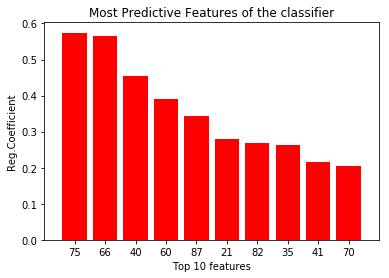


-------------------------------------------------------


LINEAR REGRESSION - LOW CRIME FEATURES:

Feature ranking based on measurements:
1.) feature 59 [PctRecImmig5], Reg.Coefficient = -0.207035
2.) feature 84 [RentLowQ], Reg.Coefficient = -0.228495
3.) feature 68 [PersPerRentOccHous], Reg.Coefficient = -0.237893
4.) feature 9 [agePct12t29], Reg.Coefficient = -0.237988
5.) feature 12 [numbUrban], Reg.Coefficient = -0.263206
6.) feature 46 [PctKids2Par], Reg.Coefficient = -0.284324
7.) feature 23 [whitePerCap], Reg.Coefficient = -0.350161
8.) feature 81 [OwnOccLowQuart], Reg.Coefficient = -0.393367
9.) feature 43 [TotalPctDiv], Reg.Coefficient = -0.537341
10.) feature 69 [PctPersOwnOccup], Reg.Coefficient = -0.702546


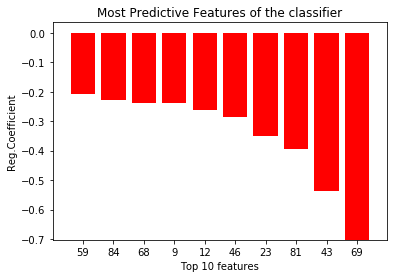

In [25]:
linReg_coeff_vals = linRegr.coef_

feature_ranks_linReg = np.argsort(linReg_coeff_vals)[::-1]
mostPred10Features_HighCrime = feature_ranks_linReg[:10]
mostPred10Features_LowCrime = feature_ranks_linReg[-10:]

print("\nLINEAR REGRESSION - HIGH CRIME FEATURES:\n")
displayTop10Features(input_df2, linReg_coeff_vals, mostPred10Features_HighCrime, 'Reg.Coefficient')

print("\n-------------------------------------------------------\n")

print("\nLINEAR REGRESSION - LOW CRIME FEATURES:\n")
displayTop10Features(input_df2, linReg_coeff_vals, mostPred10Features_LowCrime, 'Reg.Coefficient')

##### Observation:
> There are some features stated in the high crime area which are as same as in Decision tree classifier results. But, here features like "PctKids2Par", "TotalPctDiv" are identified as Low-crime indicators. The difference is that the decision trees try to **classify** the data and it shortlists a set of attributes that assist it in achieving that, whereas here, in **regression**, we try to estimate values of the crime rate. It is obvious.

### (3.b) Ridge Regression
> Ridge regression performs "L2 regularization". **Regularization** improves the conditioning of the problem and reduces the variance of the estimates. In the algorithm function, the strength of the regularization is given by the **"alpha"** factor.

In [26]:
from sklearn.linear_model import Ridge, RidgeCV

alpha_vals = np.array([10, 1, 0.1, 0.01, 0.001])
ridgeRegrCV = RidgeCV(alphas=alpha_vals, store_cv_values=True)

ridgeRegrCV.fit(features_df2, crime_df['ViolentCrimesPerPop'])

RidgeCV(alphas=array([  1.00000e+01,   1.00000e+00,   1.00000e-01,   1.00000e-02,
         1.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [27]:
ridgeRegrCV.alpha_

1.0

##### Observation: 
> Thus RidgeCV regression finds the best value of alpha as ''1", which we use to model a Ridge regressor.

In [28]:
ridgeRegr = Ridge(alpha=1.0)

ridgeRegr.fit(features_df2, crime_df['ViolentCrimesPerPop'])

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

#### (3.b.i) Estimated MSE of the model using 10-fold CV

In [29]:
#Estimation using 10-fold cross validation
cv10_ridgeReg_pred = cross_val_predict(ridgeRegr, features_df2, crime_df['ViolentCrimesPerPop'], cv=10) 
cv10_ridgeReg_mse = mean_squared_error(crime_df['ViolentCrimesPerPop'], cv10_ridgeReg_pred)
print("\nCross-validation MSE: ", cv10_ridgeReg_mse)


Cross-validation MSE:  0.0195624794757


#### (3.b.ii) MSE on the training set

In [30]:
ridgeReg_pred = ridgeRegr.predict(features_df2)
ridgeReg_mse = mean_squared_error(crime_df['ViolentCrimesPerPop'], cv10_ridgeReg_pred)
print("\nTraining-set MSE: ", ridgeReg_mse)


Training-set MSE:  0.0195624794757


#### (3.b.iv)
##### Observation:
> As we can see, the regularization as done by the ridge regressor resulted in achieving the same MSE on both prediction and evaluation. Thus the problem of **overfitting**, as possible in Linear Regression algorithm, is prevented.

### (3.c) Quadratic Polynomial Regression using Polynomial features

In [31]:
from sklearn.preprocessing import PolynomialFeatures
quadraticPoly = PolynomialFeatures(2)

polyFeatures = quadraticPoly.fit_transform(features_df2)
print("The shape of the new dataframe is: ", np.shape(polyFeatures))

The shape of the new dataframe is:  (1993, 5356)


In [32]:
linRegr2 = linear_model.LinearRegression()
linRegr2.fit(polyFeatures, crime_df['ViolentCrimesPerPop'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### (3.c.i) Estimated MSE under CV-10:

In [33]:
cv10_linRegr2_pred = cross_val_predict(linRegr2, polyFeatures, crime_df['ViolentCrimesPerPop'], cv=10) 
cv10_linRegr2_mse = mean_squared_error(crime_df['ViolentCrimesPerPop'], cv10_linRegr2_pred)
print("\nThe CV-10 MSE is: ", cv10_linRegr2_mse)


The CV-10 MSE is:  0.146410199036


#### (3.c.i) Training set MSE:

In [34]:
#Testing the regressor with the polynomial training features
linReg2_pred = linRegr2.predict(polyFeatures)

#Calculating MSE of the Regressor's prediction
linRegr2_mse = mean_squared_error(crime_df['ViolentCrimesPerPop'], linReg2_pred)
print("\nThe Training-set MSE is: ", linRegr2_mse)


The Training-set MSE is:  2.605116384e-25


#### (3.c.iii)
##### Observation:
> We see that Training-set MSE (2.60e-25) and CV-10 MSE (0.14) are **closer to 0**. The values are lesser than the linear models for the problem we saw before. Hence the estimation will be better when we implement Quadratic Polynomial Regression using Polynomial features.

## 4.) Dirty data

In [35]:
#Creating a dataframe from the given CSV file
crime_dirty_df = pd.read_csv("C:\\Users\\Chandra Balaji\\Desktop\\Notebooks\\datasets\\communities-crime-full.csv")
print("Dataframe Dimensions: ", crime_dirty_df.shape)

Dataframe Dimensions:  (1994, 128)


In [36]:
#Adding a field "highCrime" that has the classfied results
crime_dirty_df['highCrime'] = np.where(crime_dirty_df['ViolentCrimesPerPop'] > 0.1, 'true', 'false')

#Excluding the crime rate field "ViolentCrimesPerPop" from the dataset
input_dirty_df = crime_dirty_df.drop(['ViolentCrimesPerPop','communityname'], axis=1)
features_dirty = input_dirty_df.values[:, :-1]
target_dirty = crime_dirty_df.values[:,-1]

print("\nThe feature values of the dataset: \n", features_dirty)


The feature values of the dataset: 
 [[8 '?' '?' ..., '0.5' 0.32 '0.14']
 [53 '?' '?' ..., '?' 0.0 '?']
 [24 '?' '?' ..., '?' 0.0 '?']
 ..., 
 [9 '9' '80070' ..., '0' 0.91 '0.28']
 [25 '17' '72600' ..., '0' 0.22 '0.18']
 [6 '?' '?' ..., '0.5' 1.0 '0.13']]


##### Observation:  
> The full dataset has various attributes that contain missing values denoted by the symbol **"?"**, which is reflected in the above output. Such values in the dataset is incompatible with scikit-learn estimators. A basic strategy to use such incomplete datasets is to discard entire rows and/or columns containing missing values. However, we may lose data that are valuable. A better strategy is to **impute/infer the missing values.**  

>Before infering the missing values we need to convert the "?" strings in the dataset into **"NaN"** for the *Imputer* Preprocessing function of *sklearn* library to work correctly on the dataset.

In [37]:
#Converting the missing values "?" as "NaN"
features_dirty = pd.DataFrame(features_dirty)
NaN_features = features_dirty.replace(to_replace = "?", value = "NaN")

#Imputing the Missing values in the dataset. We use "mean" value strategy
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values="NaN", strategy="most_frequent" , axis=0)
tx_features = imputer.fit_transform(NaN_features)

In [38]:
#Invoking the Decision Tree Classifier with "Gini" as the quality measure
DT_Classifier2 = tree.DecisionTreeClassifier(criterion = 'gini', random_state=100, max_depth=5, min_samples_leaf=5)
DT_Classifier2.fit(tx_features, target_dirty)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [39]:
#Prediction with Decision Tree classifier
DT_dirty_pred = DT_Classifier2.predict(tx_features)

print("\nDECISION TREE CLASSIFIER WITH DIRTY DATA - PREDICTION RESULTS:\n")
prediction_metrics(target_dirty, DT_dirty_pred)


DECISION TREE CLASSIFIER WITH DIRTY DATA - PREDICTION RESULTS:

Confusion Matrix: 
 [[1105  146]
 [ 109  634]]

Accuracy(%): 
 87.21

Presicion(%): 
 91.02

Recall(%): 
 88.33


Feature ranking based on measurements:
1.) feature 48 [PctKids2Par], Gini Importance = 0.596414
2.) feature 7 [racePctWhite], Gini Importance = 0.143753
3.) feature 9 [racePctHisp], Gini Importance = 0.074979
4.) feature 75 [HousVacant], Gini Importance = 0.016443
5.) feature 2 [community], Gini Importance = 0.016350
6.) feature 30 [HispPerCap], Gini Importance = 0.014902
7.) feature 34 [PctNotHSGrad], Gini Importance = 0.013153
8.) feature 89 [MedRent], Gini Importance = 0.011361
9.) feature 79 [PctVacMore6Mos], Gini Importance = 0.010324
10.) feature 45 [TotalPctDiv], Gini Importance = 0.010059


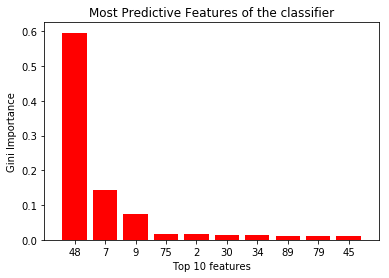

Feature ranking based on measurements:
1.) feature 47 [PctKids2Par], Gini Importance = 0.665281
2.) feature 6 [racePctWhite], Gini Importance = 0.155528
3.) feature 8 [racePctHisp], Gini Importance = 0.084692
4.) feature 74 [HousVacant], Gini Importance = 0.018573
5.) feature 29 [HispPerCap], Gini Importance = 0.016833
6.) feature 88 [MedRent], Gini Importance = 0.012833
7.) feature 78 [PctVacMore6Mos], Gini Importance = 0.011662
8.) feature 44 [TotalPctDiv], Gini Importance = 0.011362
9.) feature 42 [MalePctNevMarr], Gini Importance = 0.009494
10.) feature 0 [state], Gini Importance = 0.008023


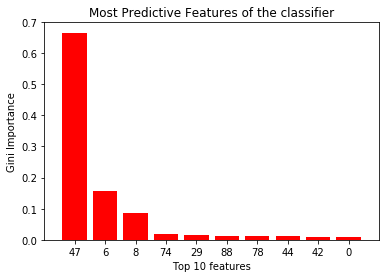

In [40]:
#Extracting the feature importances established by the classifier
f_importances2 = DT_Classifier2.feature_importances_
feature_ranks_DT2 = np.argsort(f_importances2)[::-1]

#Shortlisting the top 10 features chosen by the classifier
mostPred10Features_DT2 = feature_ranks_DT2[:10]
displayTop10Features(input_dirty_df, f_importances2, mostPred10Features_DT2, 'Gini Importance')
displayTop10Features(input_df, f_importances, mostPred10Features_DT, 'Gini Importance')


DECISION TREE CLASSIFIER ON DIRTY DATASET - CROSS VALIDATION RESULTS: 



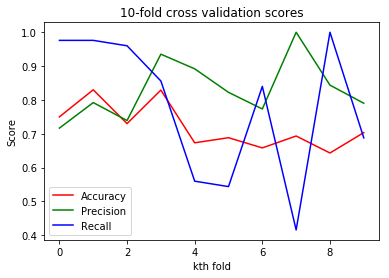

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 71.9944723618
Precision(%): 
 83.0490133993
Recall(%): 
 78.16


In [41]:
print("\nDECISION TREE CLASSIFIER ON DIRTY DATASET - CROSS VALIDATION RESULTS: \n")
cv10_evalulate(linSVC_Classifier, features_df2, target_df2)

## 6.) Additional Analysis for "Extra Credit"

### (6.b) SVM classification using Radial Basis Function (RBF) kernel:

In [42]:
svmRbf_Classifier = svm.SVC() #defaul kernel = 'rbf'
svmRbf_Classifier.fit(features_df2, target_df2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVM CLASSIFIER WITH 'RBF' KERNEL - PREDICTION RESULTS:

Confusion Matrix: 
 [[1125  125]
 [ 227  516]]

Accuracy(%): 
 82.34

Presicion(%): 
 83.21

Recall(%): 
 90.0

EVALUATION OF SVM CLASSIFIER THAT USES "RBF" KERNEL: 



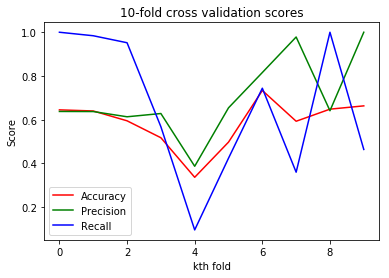

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 58.6994974874
Precision(%): 
 69.9327519357
Recall(%): 
 65.92


In [43]:
svmRbf_pred = svmRbf_Classifier.predict(features_df2)

print("\nSVM CLASSIFIER WITH 'RBF' KERNEL - PREDICTION RESULTS:\n")
prediction_metrics(target_df2, svmRbf_pred)

print("\nEVALUATION OF SVM CLASSIFIER THAT USES \"RBF\" KERNEL: \n")
cv10_evalulate(svmRbf_Classifier, features_df2, target_df2)

##### Observation:
> Comparing Prediction results and Evaluation results, we find that though the SVM classifier (with 'rbf' kernel) gives good metrics with the training data, it scores poor when it comes to generalization, with accuracy falling down to **58.69%!** So, we can't considerit as a good candidate for our analysis.


###  Random Forest Classifier:

In [44]:
from sklearn.ensemble import RandomForestClassifier
rndFrst_Classifier = RandomForestClassifier() #Default: n_instances = 10
rndFrst_Classifier.fit(features_df2, target_df2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


SVM CLASSIFIER WITH 'RBF' KERNEL - PREDICTION RESULTS:

Confusion Matrix: 
 [[1235   15]
 [   2  741]]

Accuracy(%): 
 99.15

Presicion(%): 
 99.84

Recall(%): 
 98.8

EVALUATION OF SVM CLASSIFIER THAT USES "RBF" KERNEL: 



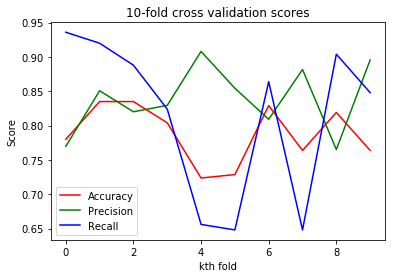

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 78.8216080402
Precision(%): 
 83.8413284955
Recall(%): 
 81.36


In [45]:
rndFrst_pred = rndFrst_Classifier.predict(features_df2)

print("\nSVM CLASSIFIER WITH 'RBF' KERNEL - PREDICTION RESULTS:\n")
prediction_metrics(target_df2, rndFrst_pred)

print("\nEVALUATION OF SVM CLASSIFIER THAT USES \"RBF\" KERNEL: \n")
cv10_evalulate(rndFrst_Classifier, features_df2, target_df2)

##### Observation:
> We can observe that not just the performance of **RandomForest classifier** on the training set is very good, it's evaluation score also is appreciable. RandomForest is an ensemble method that works by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers. Since it is **averaging out the result**, we could rely on it's performance and choose it among others.

Feature ranking based on measurements:
1.) feature 46 [PctKids2Par], Feature Importance = 0.091499
2.) feature 42 [FemalePctDiv], Feature Importance = 0.067590
3.) feature 51 [NumIlleg], Feature Importance = 0.046721
4.) feature 43 [TotalPctDiv], Feature Importance = 0.040396
5.) feature 29 [NumUnderPov], Feature Importance = 0.031969
6.) feature 45 [PctFam2Par], Feature Importance = 0.030775
7.) feature 70 [PctPersDenseHous], Feature Importance = 0.028880
8.) feature 69 [PctPersOwnOccup], Feature Importance = 0.028063
9.) feature 52 [PctIlleg], Feature Importance = 0.024184
10.) feature 5 [racePctWhite], Feature Importance = 0.023161


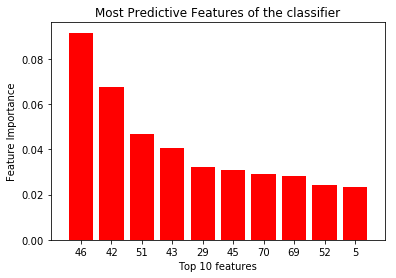

In [46]:
#Extracting the feature importances established by the classifier
f_importances_rndFrst = rndFrst_Classifier.feature_importances_
feature_ranks_rndFrst = np.argsort(f_importances_rndFrst)[::-1]

#Shortlisting the top 10 features chosen by the classifier
mostPred10Features_rndFrst = feature_ranks_rndFrst[:10]
displayTop10Features(input_df2, f_importances_rndFrst, mostPred10Features_rndFrst, 'Feature Importance')

##### Observation:
> We find that some features (MalePctNevMarr, TotalPctDiv, PctKids2Par, racePctWhite) which factors in the decision tree results arise in RandonForest classifier's prediction also. In adddition, this classifier prioritizes other attributes like "PctWorkMomYoungKids", "householdsize", etc.

### (6.c) Combining the given dataset with climate data:
>**Data:** Average Annual State Temperatures  
**Source:** https://www.currentresults.com/Weather/US/average-annual-state-temperatures.php.  

[**NOTE:** As the given crime dataset has 56 states and the climate data exists only for **50 states**, the samples belonging to the state numbers 51 to 56 are deleted while adding the climate attribute. In this operation, the final data set sample size has been reduced from 1993 to **1839**.]

In [47]:
#Creating a dataframe from the given CSV file has a newly added feature "AnnualAvgTemp"
crime_df3 = pd.read_csv("C:\\Users\\Chandra Balaji\\Desktop\\Notebooks\\datasets\\communities-crime-clean_addedClimateField.csv")
print("Dataframe Dimensions: ", crime_df3.shape)

#Adding a field "highCrime" that has the classfied results
crime_df3['highCrime'] = np.where(crime_df3['ViolentCrimesPerPop'] > 0.1, 'true', 'false')

#Excluding the crime rate field "ViolentCrimesPerPop" from the dataset
input_df3 = crime_df.drop(['ViolentCrimesPerPop','communityname'], axis=1)

#Defining the training attributes and labels for the classifier to learn
features_df3 = input_df3.values[:, :-1]
target_df3 = input_df3.values[:,-1]

#Invoking the Decision Tree Classifier with "Gini" as the quality measure
DT_Classifier3 = tree.DecisionTreeClassifier(criterion = 'gini', random_state=100, max_depth=5, min_samples_leaf=5)
DT_Classifier3.fit(features_df3, target_df3)

Dataframe Dimensions:  (1839, 105)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')


DECISION TREE CLASSIFIER WITH ADDED FEATURE "AnnualAvgTemp" - PREDICTION RESULTS:

Confusion Matrix: 
 [[1120  130]
 [ 130  613]]

Accuracy(%): 
 86.95

Presicion(%): 
 89.6

Recall(%): 
 89.6

EVALUATION OF DECISION TREE CLASSIFIER WITH NEW DATAFRAME: 



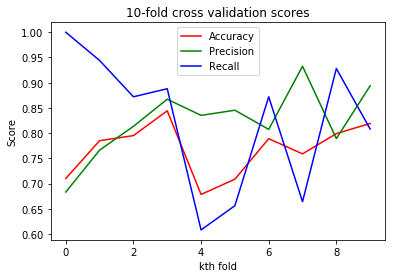

10-fold Cross validation (Mean) scores: 

Accuracy(%): 
 76.8698492462
Precision(%): 
 82.3335250431
Recall(%): 
 82.4


In [48]:
#Prediction with Decision Tree classifier
DT3_pred = DT_Classifier3.predict(features_df3)

print("\nDECISION TREE CLASSIFIER WITH ADDED FEATURE \"AnnualAvgTemp\" - PREDICTION RESULTS:\n")
prediction_metrics(target_df3, DT3_pred)

print("\nEVALUATION OF DECISION TREE CLASSIFIER WITH NEW DATAFRAME: \n")
cv10_evalulate(DT_Classifier3, features_df3, target_df3)

##### Observation:
> The decision tree classifier on the dataset newly added attribute till performs the same, giving above average results. Lets see whether the new attribute ("AnnualAvgTemp") has got into the main features (below).

Feature ranking based on measurements:
1.) feature 46 [PctKids2Par], Gini Importance = 0.596693
2.) feature 5 [racePctWhite], Gini Importance = 0.143845
3.) feature 7 [racePctHisp], Gini Importance = 0.075067
4.) feature 73 [HousVacant], Gini Importance = 0.016462
5.) feature 28 [HispPerCap], Gini Importance = 0.014920
6.) feature 32 [PctNotHSGrad], Gini Importance = 0.013168
7.) feature 87 [MedRent], Gini Importance = 0.011375
8.) feature 62 [PctSpeakEnglOnly], Gini Importance = 0.011032
9.) feature 77 [PctVacMore6Mos], Gini Importance = 0.010336
10.) feature 43 [TotalPctDiv], Gini Importance = 0.010071


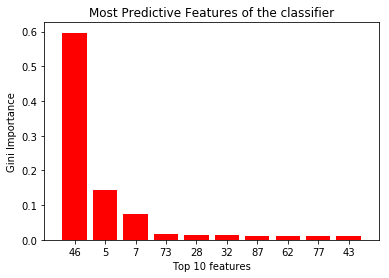

In [49]:
#Extracting the feature importances established by the classifier
f_importances3 = DT_Classifier3.feature_importances_
feature_ranks_DT3 = np.argsort(f_importances3)[::-1]

#Shortlisting the top 10 features chosen by the classifier
mostPred10Features_DT3 = feature_ranks_DT3[:10]
displayTop10Features(input_df3, f_importances3, mostPred10Features_DT3, 'Gini Importance')

##### Observation:
> We can observe that the new attribute ("AnnualAvgTemp") doesn't have any effect on the classifer's performance. So, one could say that the temperature variations don't factor in the crime rates across the country.